#### Skill Factory. DST-10. Никишин Андрей.

## Дипломный проект: «Кластеризация поисковых запросов для рекламных кампаний»
### Бизнес-цели:
- Ускорить и упростить процесс распределения поисковых запросов по группам для сотрудников отдела маркетинга компании.
- Создать возможность быстрого анализа тенденций изменения спроса в существующих товарных группах и перспективных направлениях развития ассортиментной политики.
- Реализовать функцию мониторинга ассортимента конкурирующих организаций.
- Упростить процесс выявления трендов и тенденций спроса в рабочей нише.
### Технические цели:
- Разработать инструмент автоматической обработки, очистки, фильтрации и кластеризации семантического ядра поисковых запросов.
- Добиться точности алгоритма, сопоставимой с точностью при ручной обработке запросов.

In [1]:
import pandas as pd
import numpy as np
import copy
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

from gensim.models import Word2Vec
import gensim.downloader as api
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
import re

from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")
# Увеличим дефолтный размер графиков
rcParams['figure.figsize'] = 10, 5

In [2]:
# фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимыми
RANDOM_SEED = 42

## Data
Дан предварительно вручную размеченный датасет по товарной группе "Столы" (файл Excel с тремя столбцами):
- Ключевая фраза в формате поискового запроса с использованием спецсимволов.
- Количество запросов в месяц в поисковой системе Яндекс по каждой ключевой фразе.
- Группа, к которой менеджер отдела маркетинга отнес поисковый запрос.

In [3]:
df = pd.read_excel('data/import_words.xlsx', header=None)
df.columns = ['phrase', 'count', 'group']
df

,phrase,count,group
0,письменный стол,122559,письменный
1,компьютерный стол,107513,компьютерный
2,угловой стол,28134,угловой
3,купить письменный стол,24047,письменный
4,купить компьютерный стол,23058,компьютерный
...,...,...,...
7218,оформление стола +на двоих,3,GM
7219,варианты письменных столов +для двоих детей,3,тандем
7220,стол подоконник +для двоих детей,3,LM
7221,письменный стол +для двоих детей размеры,3,GM


## План работы
### Основные тезисы
- Наша задача создать алгоритм, который максимально точно распределит данные по группам, также, как это сделал человек.
- Как показывает практика, человек, при ручной разметке данных, ошибается приблизительно в 10-15% случаев.
- Цена ошибки не высока, т. к. она нивелируется последующим автоматическим алгоритмом, регулирующим бюджет рекламных кампаний по неэффективным ключевым запросам (уменьшается бюджет запросов не приносящих продажи). Кроме того, если запрос "Купить офисный письменный стол" попадет в группу "Письменные столы", а не "Офисные столы" ничего страшного не произойдет, т. к. и в той и другой группе запрос будет считаться целевым.
- Для оценки качества алгоритма будет использоваться метрика Accuracy (точность) для датасета в целом, а также метрика Recall (полнота) для оценки распределения в каждой группе товаров.

### Цели по качеству:
- Точность менее 80% - неудовлетворительно.
- Точность от 80 до 85% - удовлетворительно.
- Точность от 86 до 90% - хорошо.
- Точность свыше 90% - отлично.

### План работы
- Очистить данные от "минус-слов" - нецелевых фраз, по которым не нужно показывать рекламные объявления.
- Показать пользователю рекомендации по выбору групп для распределения поисковых запросов.
- Распределить запросы по выбранным группам.
- Создать прототип приложения для работы пользователей без навыков программирования.

In [4]:
# Метрика
def test_metric(data):
    print('Accuracy: ', round(accuracy_score(
        data.label.to_list(), df.pred_group.to_list())*100, 2), '%')

## Посмотрим на данные

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7223 entries, 0 to 7222
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   phrase  7223 non-null   object
 1   count   7223 non-null   int64 
 2   group   7223 non-null   object
dtypes: int64(1), object(2)
memory usage: 169.4+ KB


### Пропуски
Пропусков в данном датасете нет, однако исходя из практики подготовки данных, они могут быть. Т. к. на основе данного исследования будет разработано приложение для работы сотрудников отдела маркетинга, добавим код для удаления пропусков в колонке phrase.

In [6]:
df = df.dropna(subset=['phrase'], axis=0)

### Дубли
Дубликатов в данном дата сете нет, т. к. они удалены в Excel при создании датасета, однако способ сбора данных подразумевает наличие дублей и для создания приложения необходимо добавить код для их удаления.

In [7]:
df.phrase.duplicated().sum()

0

In [8]:
df = df.drop_duplicates(subset=['phrase'])

### Количество запросов в месяц
- Числовой признак. Носит исключительно информационный характер. Будет использоваться для рекомендации по выбору групп для распределения поисковых запросов.
- В датасете присутствуют запросы с частотой более 2-х раз в месяц.
- Самый высокочастотный запрос: "письменный стол" - 122559 запросов в месяц.

In [9]:
df[df['count'] == df['count'].max()]

,phrase,count,group
0,письменный стол,122559,письменный


In [10]:
df[df['count'] == df['count'].min()].head(4)

,phrase,count,group
6955,размер столешницы письменного стола +для школь...,3,GM
6956,стол +для школьника пермь,3,GM
6957,купить стол школьника +в смоленске,3,GM
6958,модульные письменные столы +для школьников,3,LM


Количество поисковых фраз с минимальным количеством запросов в месяц.

In [11]:
len(df[df['count'] == df['count'].min()])

268

### Группы запросов
- Сотрудники вручную распределили поисковые запросы по группам.
- Создаваемый алгоритм должен распределять запросы аналогичным образом.
- Будем использовать данный признак для оценки качества алгоритма кластеризации.

In [12]:
df.group.value_counts()

GM              2484
LM               970
компьютерный     917
угловой          757
письменный       645
офис             402
школьник         374
тандем           243
шкаф             183
белый             76
маленький         62
ящик              58
надставка         52
Name: group, dtype: int64

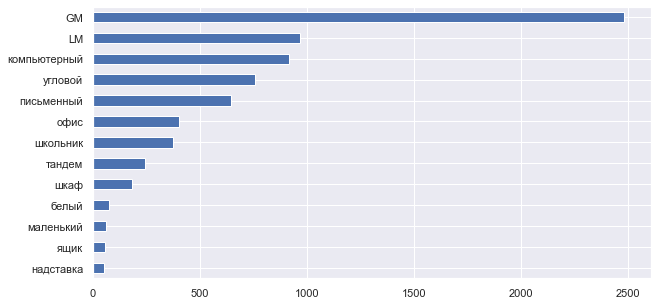

In [13]:
df.group.value_counts(ascending=True).plot(kind='barh');

**Описание признака:**
- Поисковые запросы разделены на 11 тематических групп.
- Параметрами GM и LM - отмечены фразы, которые не следует включать в рекламные кампании.
- Количество элементов в классах не сбалансировано, поэтому для оценки качества будем использовать не только метрику Accuracy, а будем также оценивать каждую группу в отдельности, что будет давать более полное представление о работе алгоритма, нежели стандартные метрики, применяемые ко всему датасету.

## Подготовка дата сета к работе

In [14]:
# Убираем размеченные данные в отдельный датасет, для ускорения работы с оставшимися данными
def transform_df(data, data_minus):
    df_tmp = data[data.pred_group != 0]
    data = data[data.pred_group == 0].reset_index(drop=True)
    data_minus = data_minus.append(df_tmp).reset_index(drop=True)
    return data, data_minus


# Создаем датасет для размеченных минус-слов
df_minus = pd.DataFrame()

Создадим колонку в которой будем записывать предсказания модели.

In [15]:
df['pred_group'] = 0

### Подготовка данных для фильтрации
- Перевести все ключевые фразы в нижний регистр.
- Провести лемматизацию (перевод слов в начальную форму).
- Очистить ключевые фразы от стоп-слов, предлогов, знаков математических операций и пунктуации.
- Сформировать списки отдельных слов по каждой ключевой фразе.

In [16]:
# Перевод в нижний регистр
df.phrase = df.phrase.apply(lambda x: x.lower())

text_batch = ' brbr '.join(df.phrase)  # Маркер для разъединения текстов


# Create lemmatizer and stopwords lists
mystem = Mystem()
russian_stopwords = stopwords.words('russian')


# Preprocess function
def preprocess_text(text):
    tokens = mystem.lemmatize(text)
    tokens = [token for token in tokens if token not in russian_stopwords and token.strip()
              not in punctuation]
    text = " ".join(tokens)
    return text

In [17]:
%%time
text_batch = preprocess_text(text_batch).split(' brbr ')

Wall time: 2.28 s


In [18]:
# Создаем столбец с обработанным текстом
df['phrase_nlp'] = text_batch

# Создаем столбец с обработанными списками слов (токенизация)
df['phrase_nlp_list'] = df.phrase_nlp.apply(lambda x: x.split(' '))

df

,phrase,count,group,pred_group,phrase_nlp,phrase_nlp_list
0,письменный стол,122559,письменный,0,письменный стол,"[письменный, стол]"
1,компьютерный стол,107513,компьютерный,0,компьютерный стол,"[компьютерный, стол]"
2,угловой стол,28134,угловой,0,угловой стол,"[угловой, стол]"
3,купить письменный стол,24047,письменный,0,купить письменный стол,"[купить, письменный, стол]"
4,купить компьютерный стол,23058,компьютерный,0,купить компьютерный стол,"[купить, компьютерный, стол]"
...,...,...,...,...,...,...
7218,оформление стола +на двоих,3,GM,0,оформление стол двое,"[оформление, стол, двое]"
7219,варианты письменных столов +для двоих детей,3,тандем,0,вариант письменный стол двое ребенок,"[вариант, письменный, стол, двое, ребенок]"
7220,стол подоконник +для двоих детей,3,LM,0,стол подоконник двое ребенок,"[стол, подоконник, двое, ребенок]"
7221,письменный стол +для двоих детей размеры,3,GM,0,письменный стол двое ребенок размер,"[письменный, стол, двое, ребенок, размер]"


## Шаг 1: Очистить данные от "минус-слов"
### Global & Local minus
Фразы, которые не требуется включать в рекламные кампании делятся на две группы:
- GM - Global minus - запросы, которые исключаются из всех рекламных кампаний, т. к. не ведут к продаже товара. Например: "Собрать письменный стол своими руками", "Купить компьютерный стол БУ". Кроме того, к этой группе относятся фразы, содержащие зарегистрированные торговые марки, которые запрещено использовать сторонним рекламодателям. Например: "Купить угловой стол в Хофф", "Купить компьютерный стол в Ситилинк"
- LM - Local minus - запросы, которые исключаются из рекламных кампаний по данной товарной группе. Например, мы не производим стеклянные столы, но производим стеллажи со стеклянными дверками. Поэтому для товарной группы "Столы" все фразы, содержащие слово "стеклянный" должны быть убраны, а для товарной группы "Библиотеки" оставлены.

Списки "минус-слов" уже собраны в компании. Будем использовать их для фильтрации поисковых запросов.

In [19]:
df_gm = pd.read_excel('data/Global_minus.xlsx', header=None)
df_gm.columns = ['word']

df_lm = pd.read_excel('data/Local_minus.xlsx', header=None)
df_lm.columns = ['word']

In [20]:
df_gm

,word
0,+как
1,руками
2,бесплатно
3,металл
4,на заказ
...,...
520,новый год
521,роман
522,расти
523,человек


In [21]:
df_lm

,word
0,стул
1,столешница
2,стеклянный
3,трансформер
4,храни
...,...
126,швейный
127,подушка
128,освещать
129,формула


Т. к. задача состоит в том, чтобы отфильтровать запросы и по глобальным, и по локальным "минус-словам", объединим их в общий датафрейм.

In [22]:
df_gm = df_gm.append(df_lm).reset_index(drop=True)

### Проблема коротких "минус-слов"
Существуют короткие "минус-слова", которые при поиске по фразам могут являться частью релевантных запросов. Например, минус-слово **"бу"** будет отфильтровывать следующие "хорошие" поисковые запросы:
- письменный стол цвет **бу**к
- стол +для **бу**хгалтера офисный
- угловые столы санкт-петер**бу**рг
- компьютерный стол +для ноут**бу**ка купить +в москве

Короткими считаются "минус-слова" до 4-х символов.

In [23]:
df_gm['len'] = df_gm.word.apply(lambda x: len(x))
df_gm[df_gm.len < 4]

,word,len
25,уфа,3
26,уфе,3
52,бу,2
53,б/у,3
126,юла,3
127,юля,3
169,юле,3
195,гдр,3
203,пнг,3
228,3д,2


Отделим их в множество для более точной фильтрации.

In [24]:
gm_set_small = set(df_gm.word[df_gm.len < 4])
df_gm = df_gm[df_gm.len > 3]
gm_set_small

{'3d',
 '3д',
 'dwg',
 'б/у',
 'бу',
 'бук',
 'гдр',
 'пнг',
 'уфа',
 'уфе',
 'юла',
 'юле',
 'юля'}

### Поиск "минус-слов" в ключевых запросах
- Объединим "минус-слова" в множество, чтобы исключить повторы, которые могли появиться при создании списков "минус-слов".
- Объединим все "минус-слова" в один поисковый запрос, чтобы не использовать цикл.
- Отфильтруем ключевые запросы, содержащие "минус-слова".

In [25]:
gm_set = set(df_gm.word)
gm_pattern = '|'.join(gm_set)

- Заменим "+" на "\\+" для правильной работы алгоритма с техническими символами, содержащимися в ключевых запросах.

In [26]:
reg = re.compile('\+')
gm_pattern = reg.sub('\+', gm_pattern)

- Размечаем данные.

In [27]:
%%time
df.pred_group = df.phrase.str.contains(
    gm_pattern).replace({True: 'Minus', False: 0})

df

Wall time: 424 ms


,phrase,count,group,pred_group,phrase_nlp,phrase_nlp_list
0,письменный стол,122559,письменный,0,письменный стол,"[письменный, стол]"
1,компьютерный стол,107513,компьютерный,0,компьютерный стол,"[компьютерный, стол]"
2,угловой стол,28134,угловой,0,угловой стол,"[угловой, стол]"
3,купить письменный стол,24047,письменный,0,купить письменный стол,"[купить, письменный, стол]"
4,купить компьютерный стол,23058,компьютерный,0,купить компьютерный стол,"[купить, компьютерный, стол]"
...,...,...,...,...,...,...
7218,оформление стола +на двоих,3,GM,Minus,оформление стол двое,"[оформление, стол, двое]"
7219,варианты письменных столов +для двоих детей,3,тандем,0,вариант письменный стол двое ребенок,"[вариант, письменный, стол, двое, ребенок]"
7220,стол подоконник +для двоих детей,3,LM,Minus,стол подоконник двое ребенок,"[стол, подоконник, двое, ребенок]"
7221,письменный стол +для двоих детей размеры,3,GM,Minus,письменный стол двое ребенок размер,"[письменный, стол, двое, ребенок, размер]"


Уберем размеченные данные в отдельный датасет, для ускорения работы с оставшимися данными.

In [28]:
df, df_minus = transform_df(df, df_minus)

Убираем короткие минус-слова точным вхождением.

In [29]:
%%time
df.pred_group = df.phrase_nlp_list.apply(
    lambda x: 'Minus' if len(set(x).intersection(gm_set_small)) != 0 else 0)
df, df_minus = transform_df(df, df_minus)

Wall time: 8.98 ms


Дочищаем данные по отдельным словам с помощью колонки 'phrase_nlp_list'.

In [30]:
df.pred_group = df.phrase_nlp.str.contains(
    gm_pattern).replace({True: 'Minus', False: 0})
df, df_minus = transform_df(df, df_minus)

df

,phrase,count,group,pred_group,phrase_nlp,phrase_nlp_list
0,письменный стол,122559,письменный,0,письменный стол,"[письменный, стол]"
1,компьютерный стол,107513,компьютерный,0,компьютерный стол,"[компьютерный, стол]"
2,угловой стол,28134,угловой,0,угловой стол,"[угловой, стол]"
3,купить письменный стол,24047,письменный,0,купить письменный стол,"[купить, письменный, стол]"
4,купить компьютерный стол,23058,компьютерный,0,купить компьютерный стол,"[купить, компьютерный, стол]"
...,...,...,...,...,...,...
3764,шкаф со столом +на двоих,3,шкаф,0,шкаф стол двое,"[шкаф, стол, двое]"
3765,большой компьютерный стол +для двоих,3,тандем,0,большой компьютерный стол двое,"[большой, компьютерный, стол, двое]"
3766,длина стола +для двоих детей,3,тандем,0,длина стол двое ребенок,"[длина, стол, двое, ребенок]"
3767,варианты письменных столов +для двоих детей,3,тандем,0,вариант письменный стол двое ребенок,"[вариант, письменный, стол, двое, ребенок]"


### Проверка точности фильтрации
- Проверка на то, не перешли ли в отфильтрованную группу релевантные поисковые запросы.
- Проверка на фильтрацию по глобальному списку "минус-слов".
- Проверка на фильтрацию по локальному списку "минус-слов".

In [31]:
df_minus[(df_minus.group != 'GM') & (df_minus.group != 'LM')]

,phrase,count,group,pred_group,phrase_nlp,phrase_nlp_list


In [32]:
df[df.group == 'GM']

,phrase,count,group,pred_group,phrase_nlp,phrase_nlp_list


In [33]:
df[df.group == 'LM']

,phrase,count,group,pred_group,phrase_nlp,phrase_nlp_list


### Выводы по данному этапу:
- Датасет ключевых запросов сократился с 7223 до 3769 строк.
- Удалось сформировать универсальную систему фильтрации датасетов, не "подогнанную" под конкретные данные.
- С помощью 3-х этапной фильтрации удалось достичь 100% точности обработки 48% данных.
- Ни одна из релевантных ключевых фраз не была убрана из датасета, в тоже время все нерелевантные запросы были отфильтрованы.

## Шаг 2: Показать пользователю рекомендации по выбору групп для распределения поисковых запросов
- Посмотрим на группы, которые выбраны людьми для распределения запросов.
- Создадим алгоритм, способный по входным данным давать рекомендации по выбору групп.
- Ограничения для алгоритма: Алгоритм не должен быть подстроен под конкретные входные данный (должен быть универсальным).
- Критерий качества данного этапа: Алгоритм в рекомендациях выдает все группы, которые были выбраны человеком при ручной обработке.

In [34]:
# Группы, выбранные пользователями
df.group.value_counts()

компьютерный    917
угловой         757
письменный      645
офис            402
школьник        374
тандем          243
шкаф            183
белый            76
маленький        62
ящик             58
надставка        52
Name: group, dtype: int64

Сотрудники отдела маркетинга разделили запросы на 11 целевых групп:
- Компьютерные столы.
- Угловые столы.
- Письменные столы.
- Столы для офиса.
- Столы для детей и школьников.
- Столы для двоих детей (тандем).
- Столы со шкафом (наборы мебели).
- Белые столы.
- Маленькие столы.
- Столы с ящиками.
- Столы с надставками.

### Частота встречаемости слов
Попробуем простой быстрый алгоритм.

In [35]:
# Объединим запросы в общий список и делим по словам
text_batch = ' '.join(df.phrase_nlp).split(' ')  # Маркер для разъединения текстов

# Создадим словарь уникальных слов
dict_set_words = dict.fromkeys(set(text_batch))

Посчитаем частоту встречаемости каждого слова в запросах.

In [36]:
%%time
for word in dict_set_words.keys():
    dict_set_words[word] = text_batch.count(word)

Wall time: 144 ms


Создадим датафрем для отображения данных для пользователя.

In [37]:
df_count_words = pd.DataFrame()
df_count_words['words'] = list(dict_set_words.keys())
df_count_words['frequency'] = list(dict_set_words.values())

df_count_words.sort_values(['frequency'], ascending=False).head(20)

,words,frequency
154,стол,3775
346,компьютерный,1392
115,письменный,1175
168,угловой,913
347,купить,583
239,школьник,486
456,офисный,389
224,двое,186
711,москва,183
674,белый,137


**Предварительный вывод:**
- Получили алгоритм частоты встречаемости слов в поисковых запросах.
- Алгоритм не учитывает количество запросов в месяц, а лишь частоту встречаемости.
- Алгоритм показывает все целевые группы, кроме "маленькие столы".

### Частота встречаемости слов с учетом количества запросов в месяц
- Построим алгоритм, учитывающий не только частоту встречаемости слова в запросах, но и частоту самих запросов пользователями.
- Это даст более правильные рекомендации по выбору групп для отдела маркетинга.

In [38]:
%%time
for word in dict_set_words.keys():
    dict_set_words[word] = df.apply(
        (lambda x: x['count'] if word in x['phrase_nlp_list'] else 0), axis=1).sum()

df_count_words['count'] = list(dict_set_words.values())
df_count_words.sort_values(['count'], ascending=False).head(20)

Wall time: 18.9 s


,words,frequency,count
154,стол,3775,790854
115,письменный,1175,335221
346,компьютерный,1392,302578
347,купить,583,133844
168,угловой,913,105511
239,школьник,486,80355
711,москва,183,57979
456,офисный,389,38763
557,недорого,119,35825
358,ящик,111,28481


### Выводы по данному этапу:
- Получили алгоритм, который показал все рекомендации, которые ранее были выбраны в ручном режиме пользователями.
- Алгоритм учитывает частоту встречаемости слов в запросах.
- Алгоритм учитывает также количество поисковых запросов в месяц с содержанием каждого слова.
- Двойной цикл перебора значений работает достаточно медленно. При создании приложения для пользователей нужно будет подумать над оптимизацией алгоритма работы.

## Шаг 3: Распределить запросы по выбранным группам
- Подготовка данных для NLP-модели.
- Распределение запросов по выбранным группам.
- Анализ качества алгоритма, настройка гиперпараметров и тестирование идей по оптимизации результата.

### Подготовка данных для NLP-модели
- Лемматизация данных, перевод слов в нижний регистр, удаление стоп-слов, дубликатов, знаков математических операций и пунктуации были проведены ранее.
- Необходимо также удалить цифры и слова менее 3-х символов, как не несущие значимой информации.
- Провести добавление частеречного тэга для каждого слова (тэг означающий часть речи), т. к. это необходимо для работы выбранной модели.

In [39]:
# Удаляем цифры и слова менее 3-х символов
text_batch = text_batch = ' brbr '.join(df.phrase_nlp)
text_batch = re.sub('\s\w*\d+\w*\s', ' ', text_batch)
text_batch = re.sub('\s\S\s|\s\S\S\s', ' ', text_batch)
text_batch = text_batch.split(' brbr ')

df.phrase_nlp = text_batch
df.phrase_nlp_list = df.phrase_nlp.apply(lambda x: x.split(' '))

**Добавление частеречного тэга для каждого слова**
- Подготовка данных.

In [40]:
batch_txt = set(' '.join(df.phrase_nlp).split(' '))
batch_txt = ' '.join(batch_txt)

In [41]:
%%time
processed = mystem.analyze(batch_txt)

Wall time: 1.04 s


- Добавление частеречного тэга.

In [42]:
%%time
# Соответствие тегов mystem тегам upos
mystem2upos = {
    'A': 'ADJ',
    'ADV': 'ADV',
    'ADVPRO': 'ADV',
    'ANUM': 'ADJ',
    'APRO': 'DET',
    'COM': 'ADJ',
    'CONJ': 'SCONJ',
    'INTJ': 'INTJ',
    'NONLEX': 'X',
    'NUM': 'NUM',
    'PART': 'PART',
    'PR': 'ADP',
    'S': 'NOUN',
    'SPRO': 'PRON',
    'UNKN': 'X',
    'V': 'VERB'
}

change_dict = {}
for word in processed:
    try:
        lemma = word['analysis'][0]['lex']
        pos = word['analysis'][0]['gr'].split(',')[0]
        pos = pos.split("=")[0].strip()
        change_dict[lemma] = lemma + '_' + mystem2upos[pos]
    except:
        continue

Wall time: 996 µs


- Создадим новый признак в датасете.

In [43]:
def change_tags(phrase_list):
    tags_phrase = []
    for word in phrase_list:
        try:
            tags_phrase.append(change_dict[word])
        except:
            continue

    return tags_phrase

In [44]:
%%time
df['phrase_upos_list'] = df.phrase_nlp_list.apply(change_tags)

Wall time: 4.99 ms


**Тест на пустые списки**
- При дополнительной очистке данных могли образоваться строки с пустыми списками слов.
- Перед передачей данных в модель необходимо убедиться, что для каждого поискового запроса существует непустой список слов с частеречным тэгом.
- В приложении для пользователей будет необходимо предусмотреть очистку данных от запросов не содержащих списков слов с частеречным тэгом.

In [45]:
df['count_words'] = df.phrase_upos_list.apply(lambda x: len(x))
df.count_words.value_counts()

3    1499
4    1285
2     537
5     404
6      44
Name: count_words, dtype: int64

- В нашем случае все запросы имеют списки слов с частеречным тэгом, однако для пользовательского приложения предусмотрим функцию очистки датасета от пустых запросов.

In [46]:
df = df[df.count_words != 0].reset_index(drop=True)

**Создадим числовые обозначения для существующих групп для удобства оценки качества модели.**

In [47]:
labels = {}
for i, label in enumerate(df.group.unique()):
    labels[label] = i

df['label'] = df.group.replace(to_replace=labels)

labels

{'письменный': 0,
 'компьютерный': 1,
 'угловой': 2,
 'школьник': 3,
 'офис': 4,
 'белый': 5,
 'ящик': 6,
 'тандем': 7,
 'надставка': 8,
 'маленький': 9,
 'шкаф': 10}

In [48]:
df

,phrase,count,group,pred_group,phrase_nlp,phrase_nlp_list,phrase_upos_list,count_words,label
0,письменный стол,122559,письменный,0,письменный стол,"[письменный, стол]","[письменный_ADJ, стол_NOUN]",2,0
1,компьютерный стол,107513,компьютерный,0,компьютерный стол,"[компьютерный, стол]","[компьютерный_ADJ, стол_NOUN]",2,1
2,угловой стол,28134,угловой,0,угловой стол,"[угловой, стол]","[угловой_ADJ, стол_NOUN]",2,2
3,купить письменный стол,24047,письменный,0,купить письменный стол,"[купить, письменный, стол]","[купить_VERB, письменный_ADJ, стол_NOUN]",3,0
4,купить компьютерный стол,23058,компьютерный,0,купить компьютерный стол,"[купить, компьютерный, стол]","[купить_VERB, компьютерный_ADJ, стол_NOUN]",3,1
...,...,...,...,...,...,...,...,...,...
3764,шкаф со столом +на двоих,3,шкаф,0,шкаф стол двое,"[шкаф, стол, двое]","[шкаф_NOUN, стол_NOUN, двое_NUM]",3,10
3765,большой компьютерный стол +для двоих,3,тандем,0,большой компьютерный стол двое,"[большой, компьютерный, стол, двое]","[большой_ADJ, компьютерный_ADJ, стол_NOUN, дво...",4,7
3766,длина стола +для двоих детей,3,тандем,0,длина стол двое ребенок,"[длина, стол, двое, ребенок]","[длина_NOUN, стол_NOUN, двое_NUM, ребенок_NOUN]",4,7
3767,варианты письменных столов +для двоих детей,3,тандем,0,вариант письменный стол двое ребенок,"[вариант, письменный, стол, двое, ребенок]","[вариант_NOUN, письменный_ADJ, стол_NOUN, двое...",5,7


### Распределение запросов по выбранным группам
Загрузим предварительно обученную модель
- Библиотека Gensim, обученная модель: word2vec-ruscorpora-300.
- Проект RusVectōrēs.
- Входит в стандартный api библиотеки gensim.
- 223Мб
- 184973 векторов.
- Обучена на полном национальном корпусе русского языка (НКРЯ).

Ссылки:
- НКРЯ: https://ruscorpora.ru/new/
- RusVectōrēs: https://rusvectores.org/ru/
- Gensim: https://radimrehurek.com/gensim/index.html

In [49]:
model_words = api.load('word2vec-ruscorpora-300')

Создадим эмбеддинги для каждого поискового запроса.

In [50]:
# Список всех запросов с разделением по словам
docs = df.phrase_upos_list.to_list()

# Посмотрим 10 первых примеров
for i in range(10):
    print(docs[i], end='\n')

['письменный_ADJ', 'стол_NOUN']
['компьютерный_ADJ', 'стол_NOUN']
['угловой_ADJ', 'стол_NOUN']
['купить_VERB', 'письменный_ADJ', 'стол_NOUN']
['купить_VERB', 'компьютерный_ADJ', 'стол_NOUN']
['стол_NOUN', 'школьник_NOUN']
['стол_NOUN', 'офисный_ADJ']
['письменный_ADJ', 'стол_NOUN', 'школьник_NOUN']
['угловой_ADJ', 'компьютерный_ADJ', 'стол_NOUN']
['письменный_ADJ', 'стол_NOUN', 'москва_NOUN']


In [51]:
# Средний эмбеддинг по словам
def doc_vectorizer(doc, model):
    doc_vector = []
    num_words = 0
    for word in doc:
        try:
            if num_words == 0:
                doc_vector = model[word]
            else:
                doc_vector = np.add(doc_vector, model[word])
            num_words += 1
        except:
            pass

    return np.asarray(doc_vector) / num_words

In [52]:
# Создадим эмбеддинги для запросов
X = []
for doc in docs:
    X.append(doc_vectorizer(doc, model_words))

In [53]:
# Проверим размер вектора для запросов
print(np.asarray(X).shape)

(3769, 300)


**Создадим эмбеддинги таргетов.**
- Они будут являться центрами кластеров.
- Выбирать будем только те, которые есть в списке рекомендаций пользователю, сформированном на шаге 2.
- Выберем таргеты, соответствующие тем, которые выбраны людьми, для возможности анализа качества работы алгоритма кластеризации.

In [54]:
targets = [['письменный'], ['компьютерный'], ['угловой'], ['школьник', 'детский'], [
    'офисный'], ['белый'], ['ящик'], ['двое'], ['надстройка'], ['маленький'], ['шкафчик']]

# Вспомогательная переменная (число таргетов, которые ввел человек)
len_targets = len(targets)

Добавим частеречные тэги в таргеты.

In [55]:
targets_tags = []
for target in targets:
    target_tmp = []
    for word in target:
        target_tmp.append(change_dict[word])
    targets_tags.append(target_tmp)

targets_tags

[['письменный_ADJ'],
 ['компьютерный_ADJ'],
 ['угловой_ADJ'],
 ['школьник_NOUN', 'детский_ADJ'],
 ['офисный_ADJ'],
 ['белый_ADJ'],
 ['ящик_NOUN'],
 ['двое_NUM'],
 ['надстройка_NOUN'],
 ['маленький_ADJ'],
 ['шкафчик_NOUN']]

Создадим эмбеддинги.

In [56]:
# Составляем эмбеддинги для таргетов
y = []
for target in targets_tags:
    y.append(doc_vectorizer(target, model_words))

# Проверим размер вектора для таргетов
print(np.asarray(y).shape)

(11, 300)


### Prediction
- Будем использовать функцию косинусного сходства между вектором каждой фразы и центрами кластеров, которая возвращает вероятность отношения фразы к каждому кластеру.
- Будем относить поисковую фразу к кластеру с максимальной вероятностью попадания.
- [Подробнее о косинусном сходстве](https://ru.wikipedia.org/wiki/%D0%92%D0%B5%D0%BA%D1%82%D0%BE%D1%80%D0%BD%D0%B0%D1%8F_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C).

In [57]:
%%time
for i in range(0, len(df)):
    df.at[i, 'pred_group'] = np.argmax(
        model_words.cosine_similarities(X[i], vectors_all=y))

Wall time: 213 ms


In [58]:
df

,phrase,count,group,pred_group,phrase_nlp,phrase_nlp_list,phrase_upos_list,count_words,label
0,письменный стол,122559,письменный,0,письменный стол,"[письменный, стол]","[письменный_ADJ, стол_NOUN]",2,0
1,компьютерный стол,107513,компьютерный,1,компьютерный стол,"[компьютерный, стол]","[компьютерный_ADJ, стол_NOUN]",2,1
2,угловой стол,28134,угловой,2,угловой стол,"[угловой, стол]","[угловой_ADJ, стол_NOUN]",2,2
3,купить письменный стол,24047,письменный,0,купить письменный стол,"[купить, письменный, стол]","[купить_VERB, письменный_ADJ, стол_NOUN]",3,0
4,купить компьютерный стол,23058,компьютерный,1,купить компьютерный стол,"[купить, компьютерный, стол]","[купить_VERB, компьютерный_ADJ, стол_NOUN]",3,1
...,...,...,...,...,...,...,...,...,...
3764,шкаф со столом +на двоих,3,шкаф,10,шкаф стол двое,"[шкаф, стол, двое]","[шкаф_NOUN, стол_NOUN, двое_NUM]",3,10
3765,большой компьютерный стол +для двоих,3,тандем,7,большой компьютерный стол двое,"[большой, компьютерный, стол, двое]","[большой_ADJ, компьютерный_ADJ, стол_NOUN, дво...",4,7
3766,длина стола +для двоих детей,3,тандем,7,длина стол двое ребенок,"[длина, стол, двое, ребенок]","[длина_NOUN, стол_NOUN, двое_NUM, ребенок_NOUN]",4,7
3767,варианты письменных столов +для двоих детей,3,тандем,0,вариант письменный стол двое ребенок,"[вариант, письменный, стол, двое, ребенок]","[вариант_NOUN, письменный_ADJ, стол_NOUN, двое...",5,7


Визуализация кластеризации
Применим t-SNE метод понижения размерности векторов, для преобразования их к двум координатам, чтобы получить возможность отобразить их на диаграмме.

In [59]:
# Создаём объект для выполнения t-SNE
tsne = TSNE(n_components=2, random_state=RANDOM_SEED, verbose=1)

# Объединяем X и y для корректного обучения и трансформации
Xy = X + y

# Преобразуем данные, понизив размерность с 300 до 2
Xy = tsne.fit_transform(Xy)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3780 samples in 0.194s...
[t-SNE] Computed neighbors for 3780 samples in 6.864s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3780
[t-SNE] Computed conditional probabilities for sample 2000 / 3780
[t-SNE] Computed conditional probabilities for sample 3000 / 3780
[t-SNE] Computed conditional probabilities for sample 3780 / 3780
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.640984
[t-SNE] KL divergence after 1000 iterations: 1.439012


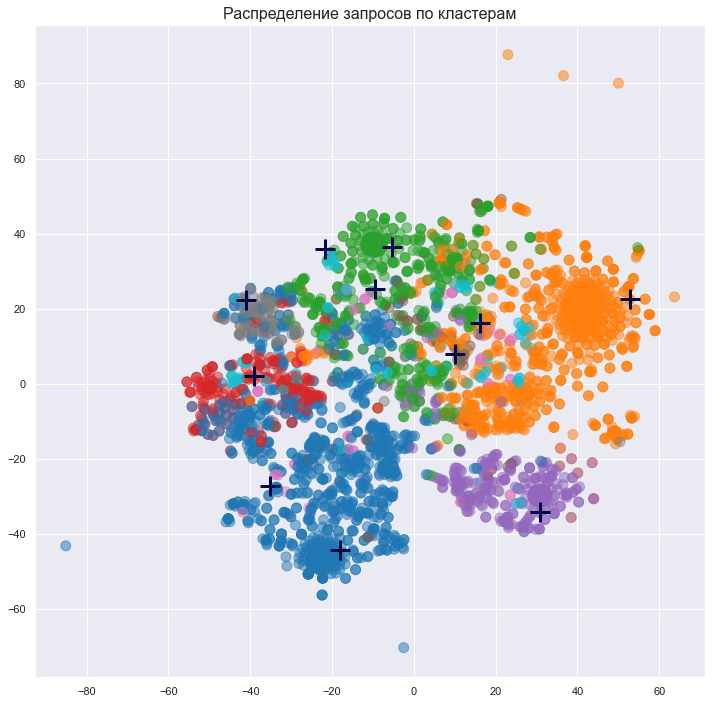

In [60]:
# Диаграмма
plt.rcParams['figure.figsize'] = 12, 12
plt.scatter(Xy[0:-len(y), 0], Xy[:-len(y), 1],
            c=df.pred_group, s=100, alpha=.5, cmap='tab10')
plt.scatter(Xy[-len(y):, 0], Xy[-len(y):, 1],
            c='#030847', s=400, marker='+', linewidths=3)
plt.title('Распределение запросов по кластерам', fontsize=16)
plt.show()

### Оценим качество

In [61]:
test_metric(df)

Accuracy:  77.45 %


**Предварительный вывод:**
- Неплохой результат, однако недостаточный для установленных критериев.
- Некоторые центры кластеров расположены достаточно близко.
- Эмбеддинги запросов из разных групп на диаграмме пересекаются между собой.
- Попробуем разобраться с причинами ошибок.

In [62]:
# Пример ошибочных предсказаний
df[(df.label == 4) & (df.pred_group != 4)].head(10)

,phrase,count,group,pred_group,phrase_nlp,phrase_nlp_list,phrase_upos_list,count_words,label
45,стол офисный угловой,1494,офис,2,стол офисный угловой,"[стол, офисный, угловой]","[стол_NOUN, офисный_ADJ, угловой_ADJ]",3,4
260,стол офисный белый,315,офис,5,стол офисный белый,"[стол, офисный, белый]","[стол_NOUN, офисный_ADJ, белый_ADJ]",3,4
319,угловой стол +для офиса,250,офис,2,угловой стол офис,"[угловой, стол, офис]","[угловой_ADJ, стол_NOUN, офис_NOUN]",3,4
320,стол письменный офисный,249,офис,0,стол письменный офисный,"[стол, письменный, офисный]","[стол_NOUN, письменный_ADJ, офисный_ADJ]",3,4
339,стол офисный угловой +с тумбой,231,офис,2,стол офисный угловой тумба,"[стол, офисный, угловой, тумба]","[стол_NOUN, офисный_ADJ, угловой_ADJ, тумба_NOUN]",4,4
657,письменный стол +для офиса,109,офис,0,письменный стол офис,"[письменный, стол, офис]","[письменный_ADJ, стол_NOUN, офис_NOUN]",3,4
838,стол офисный +с ящиками,87,офис,6,стол офисный ящик,"[стол, офисный, ящик]","[стол_NOUN, офисный_ADJ, ящик_NOUN]",3,4
899,компьютерный стол +для офиса,79,офис,1,компьютерный стол офис,"[компьютерный, стол, офис]","[компьютерный_ADJ, стол_NOUN, офис_NOUN]",3,4
936,белый офисный стол купить,75,офис,5,белый офисный стол купить,"[белый, офисный, стол, купить]","[белый_ADJ, офисный_ADJ, стол_NOUN, купить_VERB]",4,4
964,маленькие офисные столы,72,офис,9,маленький офисный стол,"[маленький, офисный, стол]","[маленький_ADJ, офисный_ADJ, стол_NOUN]",3,4


**Что произошло?**
- Видно, что во многих случаях в ключевой фразе присутствуют несколько слов, относящихся к разным целевым группам (кластерам). В этом случае алгоритм не всегда относит фразу к той же целевой группе, к которой фразу отнес человек.
- Данная ситуация возникает из-за того, что человек кроме выбора целевых групп, определяет приоритет отношения фразы к той или иной группе, а наш алгоритм этого пока не делает. Например, запрос "Стол офисный угловой" человек относит к категории "Офисный", давая этой группе приоритет, перед группой "Угловой".
- Добавим алгоритму вес групп, также, как это сделал бы пользователь.

### Коэффициент важности
- Офисный стол - 11
- Столы со шкафом - 10
- Столы для двоих (Тандем) - 9
- Угловые столы - 8
- Столы с надставкой - 7
- Белые столы - 6
- Столы для детей и школьников - 5
- Столы с ящиками - 4
- Маленькие столы - 3
- Компьютерные столы - 2
- Письменные столы - 1

In [63]:
# Вектор важности групп
imp_vec = np.array([1, 2, 8, 5, 11, 6, 4, 9, 7, 3, 10])

Посмотрим, как формируются предсказания для каждой выбранной группы. Для примера возьмем запрос "Стол письменный офисный" с индексом 320.

In [64]:
print(df.iloc[320].phrase)
print()
print(model_words.cosine_similarities(X[320], vectors_all=y))
print()
print(labels)

стол письменный офисный

[0.80738026 0.3665726  0.32491693 0.24915333 0.65895164 0.2657064
 0.44410288 0.24908534 0.21258931 0.2712772  0.5127257 ]

{'письменный': 0, 'компьютерный': 1, 'угловой': 2, 'школьник': 3, 'офис': 4, 'белый': 5, 'ящик': 6, 'тандем': 7, 'надставка': 8, 'маленький': 9, 'шкаф': 10}


### Идея корректировки распределения по классам с учетом коэффициента важности групп
- Видно, что алгоритм на 80% относит данный запрос к группе "Письменные столы", на 65% к группе "Офисные столы" и на 51% к группе "Столы со шкафами".
- Остальные вероятности ниже 50%.
- Идея - отсекать все группы с вероятностью менее определенного порогового значения (гиперпараметр), а из оставшихся групп выбирать ту, которая имеет больший коэффициент важности.

### Подберем параметр порогового значения на имеющихся данных

In [65]:
acc_list = []
for lim in np.arange(0.4, 0.8, 0.01):
    for i in range(0, len(df)):
        df.at[i, 'pred_group'] = np.argmax(
            (model_words.cosine_similarities(X[i], vectors_all=y) > lim) * imp_vec)
    acc = round(accuracy_score(df.label, df.pred_group.to_list())*100, 2)
    acc_list.append(acc)
    print('Accuracy: ', acc, '% - Пророг: ', round(lim, 2))

Accuracy:  16.26 % - Пророг:  0.4
Accuracy:  17.38 % - Пророг:  0.41
Accuracy:  19.18 % - Пророг:  0.42
Accuracy:  21.94 % - Пророг:  0.43
Accuracy:  26.32 % - Пророг:  0.44
Accuracy:  31.04 % - Пророг:  0.45
Accuracy:  36.32 % - Пророг:  0.46
Accuracy:  41.92 % - Пророг:  0.47
Accuracy:  55.51 % - Пророг:  0.48
Accuracy:  60.73 % - Пророг:  0.49
Accuracy:  68.13 % - Пророг:  0.5
Accuracy:  76.89 % - Пророг:  0.51
Accuracy:  80.68 % - Пророг:  0.52
Accuracy:  83.42 % - Пророг:  0.53
Accuracy:  85.14 % - Пророг:  0.54
Accuracy:  85.41 % - Пророг:  0.55
Accuracy:  84.96 % - Пророг:  0.56
Accuracy:  83.55 % - Пророг:  0.57
Accuracy:  82.06 % - Пророг:  0.58
Accuracy:  80.58 % - Пророг:  0.59
Accuracy:  78.27 % - Пророг:  0.6
Accuracy:  75.8 % - Пророг:  0.61
Accuracy:  72.72 % - Пророг:  0.62
Accuracy:  69.25 % - Пророг:  0.63
Accuracy:  65.59 % - Пророг:  0.64
Accuracy:  60.97 % - Пророг:  0.65
Accuracy:  56.01 % - Пророг:  0.66
Accuracy:  52.4 % - Пророг:  0.67
Accuracy:  48.47 % - Прор

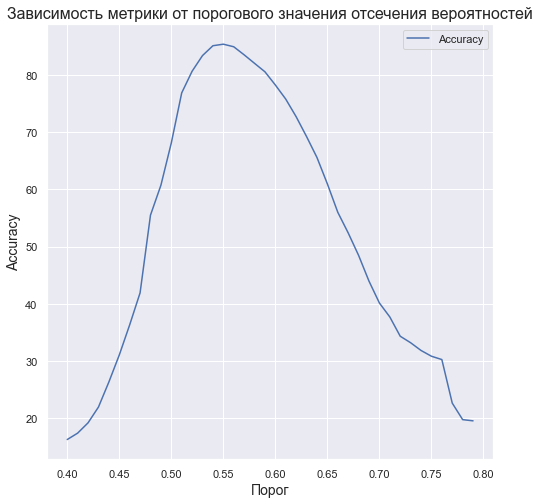

In [66]:
f, ax = plt.subplots(figsize=(8, 8))
ax.plot(np.arange(0.4, 0.8, 0.01), acc_list)
ax.legend(['Accuracy'])
ax.set_title(
    'Зависимость метрики от порогового значения отсечения вероятностей', fontsize=16)
ax.set_xlabel('Порог', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14);

In [67]:
# Сформируем предсказание с оптимальным порогом отсечения вероятностей
lim = 0.55
for i in range(0, len(df)):
    df.at[i, 'pred_group'] = np.argmax(
        (model_words.cosine_similarities(X[i], vectors_all=y) > lim) * imp_vec)

test_metric(df)

Accuracy:  85.41 %


**Предварительный вывод:**
- Идея добавления коэффициента важности групп оправдалась.
- Произведен подбор гиперпараметра отсечки вероятностей попадания запроса в целевые группы.
- При росте порогового значения, значение метрики растет и при значении порога 0,55, метрика достигает максимального показателя 85,43%, что уже является хорошим результатом по установленным критериям оценки.
- При дальнейшем росте значения параметра отсечки, значение метрики начинает уменьшаться, т. к. "правильные" группы не достигают порогового значения и отсекаются.

### Уточнение центров кластеров
Существует предположение, что если после распределения поисковых запросов по группам дать пользователю подтвердить правильность распределения некоторых запросов, а потом на основе подтвержденных запросов скорректировать центры кластеров, результат распределения можно будет улучшить. Проверим эту гипотезу.

In [68]:
# Добавим признак подтверждения правильности отношения запроса к группе
df['label_conf'] = 0

Имитируем работу пользовательского приложения:
- Предположим, что пользователь отметил n запросов, как правильно распределенные.
- Отметим в датафреме n правильно распределенных запросов для тестирования гипотезы.

In [69]:
n = 100
for i in range(0, len_targets):
    indxs = df[(df.label == i) & (df.pred_group == i)].head(n).index
    for indx in indxs:
        df.at[indx, 'label_conf'] = 1

df

,phrase,count,group,pred_group,phrase_nlp,phrase_nlp_list,phrase_upos_list,count_words,label,label_conf
0,письменный стол,122559,письменный,0,письменный стол,"[письменный, стол]","[письменный_ADJ, стол_NOUN]",2,0,1
1,компьютерный стол,107513,компьютерный,1,компьютерный стол,"[компьютерный, стол]","[компьютерный_ADJ, стол_NOUN]",2,1,1
2,угловой стол,28134,угловой,2,угловой стол,"[угловой, стол]","[угловой_ADJ, стол_NOUN]",2,2,1
3,купить письменный стол,24047,письменный,0,купить письменный стол,"[купить, письменный, стол]","[купить_VERB, письменный_ADJ, стол_NOUN]",3,0,1
4,купить компьютерный стол,23058,компьютерный,1,купить компьютерный стол,"[купить, компьютерный, стол]","[купить_VERB, компьютерный_ADJ, стол_NOUN]",3,1,1
...,...,...,...,...,...,...,...,...,...,...
3764,шкаф со столом +на двоих,3,шкаф,10,шкаф стол двое,"[шкаф, стол, двое]","[шкаф_NOUN, стол_NOUN, двое_NUM]",3,10,0
3765,большой компьютерный стол +для двоих,3,тандем,7,большой компьютерный стол двое,"[большой, компьютерный, стол, двое]","[большой_ADJ, компьютерный_ADJ, стол_NOUN, дво...",4,7,0
3766,длина стола +для двоих детей,3,тандем,7,длина стол двое ребенок,"[длина, стол, двое, ребенок]","[длина_NOUN, стол_NOUN, двое_NUM, ребенок_NOUN]",4,7,0
3767,варианты письменных столов +для двоих детей,3,тандем,7,вариант письменный стол двое ребенок,"[вариант, письменный, стол, двое, ребенок]","[вариант_NOUN, письменный_ADJ, стол_NOUN, двое...",5,7,0


Сформируем новые центры кластеров с использованием подтвержденных запросов.

In [70]:
%%time
targets_usr = copy.deepcopy(targets)
for i in range(0, len_targets):
    phrases_tmp = df[(df.pred_group == i) & (
        df.label_conf == 1)]['phrase_upos_list'].to_list()
    for phrase in phrases_tmp:
        for word in phrase:
            targets_usr[i].append(word)

Wall time: 20 ms


In [71]:
# Составляем эмбеддинги для таргетов
y = []
for target in targets_usr:
    y.append(doc_vectorizer(target, model_words))

# Проверим размер вектора для таргетов
print(np.asarray(y).shape)

(11, 300)


### Prediction

In [72]:
%%time
for i in range(0, len(df)):
    df.at[i, 'pred_group'] = np.argmax(
        model_words.cosine_similarities(X[i], vectors_all=y))

Wall time: 198 ms


### Визуализация результата

In [73]:
# Создаём объект для выполнения t-SNE
tsne = TSNE(n_components=2, random_state=RANDOM_SEED, verbose=1)

# Объединяем X и y для корректного обучения и трансформации
Xy = X + y

# Преобразуем данные, понизив размерность с 300 до 2
Xy = tsne.fit_transform(Xy)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3780 samples in 0.203s...
[t-SNE] Computed neighbors for 3780 samples in 6.856s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3780
[t-SNE] Computed conditional probabilities for sample 2000 / 3780
[t-SNE] Computed conditional probabilities for sample 3000 / 3780
[t-SNE] Computed conditional probabilities for sample 3780 / 3780
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.212708
[t-SNE] KL divergence after 1000 iterations: 1.485739


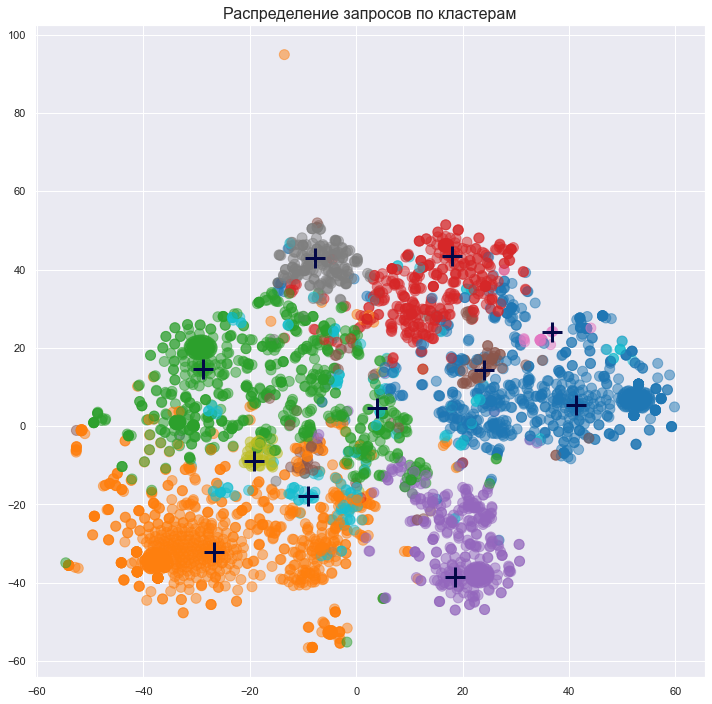

In [74]:
# Диаграмма
plt.rcParams['figure.figsize'] = 12, 12
plt.scatter(Xy[0:-len(y), 0], Xy[:-len(y), 1],
            c=df.pred_group, s=100, alpha=.5, cmap='tab10')
plt.scatter(Xy[-len(y):, 0], Xy[-len(y):, 1],
            c='#030847', s=400, marker='+', linewidths=3)
plt.title('Распределение запросов по кластерам', fontsize=16)
plt.show()

### Метрика

In [75]:
test_metric(df)

Accuracy:  86.65 %


**Предварительный вывод:**
- Идея уточнения центров кластеров за счет подтвержденных запросов оправдалась.
- Значение метрики возросло до 86,6%

### Выводы по данному этапу:
- Проверено несколько вариантов распределения поисковых запросов по выбранным группам.
- В итоговый ноутбук включены идеи, которые дали положительный результат по улучшению качества алгоритма.
- Удалось достичь точности распределения отфильтрованных данных на уровне 86,6%, что является хорошим результатом по установленным критериям.
- Если учесть тот факт, что ранее 48% данных были отфильтрованы со 100% точностью, суммарный итог последовательной работы алгоритмов даст следующий результат: 0,48 х 100% + 0,52 х 86,6% = 93% - что является отличным результатом, превосходящим ручное распределение запросов по группам пользователями.

## Шаг 4: Пользовательское приложение
- Конечной целью проекта будет создание приложения для удобного распределения поисковых запросов по группам обычными пользователями.
- В данной работе будут сформированы основные принципы его функционирования и сделан тестовый прототип. Далее задача будет включена в план развития информационной инфраструктуры предприятия.

### Общие принципы
- Пользователь загружает файлы с поисковыми запросами и минус-словами.
- Алгоритм фильтрует поисковые запросы от минус-слов и показывает рекомендации по выбору групп.
- Пользователь выбирает группы, по которым необходимо распределить запросы в порядке желаемого приоритета.
- Алгоритм распределяет запросы по группам и показывает пользователю результат на экране.
- Пользователь может переносить запросы из группы в группу, а также подтверждать правильность распределения по каждому запросу.
- Также необходимо предусмотреть возможность перераспределения неподтвержденных поисковых запросов скорректировав центры кластеров с помощью запросов, подтвержденных пользователем.

### Прототип
- Создан API сервис на Flask, который распределяет поисковые запросы по группам и отдает на "фронт" результаты распределения.
- Заказан и разработан пользовательский интерфейс на JS и React, который взаимодействует с API сервисом.

Ссылки:
- API: https://github.com/nikishin-aw/words_app/blob/main/app.py
- Фронт: https://github.com/nikishin-aw/words_app/tree/main/build

![](data/app.jpg)

## Выводы по проекту
- Проведена многоэтапная аналитическая работа по выбору алгоритмов подготовки, фильтрации и распределения поисковых запросов по необходимым группам.
- Удалось достичь высокой скорости и точности работы алгоритмов, что позволит пользователям обрабатывать более широкий спектр целевых запросов, выявляя тенденции движения рынка мебели.
- Достигнута общая точность работы алгоритма на уровне 93%, что превосходит точность ручного распределения поисковых запросов.
- Сформированы основные принципы работы пользовательского приложения и создан прототип для тестирования.